In [71]:
import requests
import json
from bs4 import BeautifulSoup

import google.generativeai as genai
import os
from dotenv import load_dotenv
load_dotenv('.env')
import pandas as pd
import matplotlib.pyplot as plt

import tiktoken
import seaborn as sns

# QUESTÃO 4

In [15]:
URL = "https://jornal.usp.br/todas-as-noticias/"

def coletar_manchetes(url):
    try:
        response = requests.get(url)
        response.raise_for_status() 

        soup = BeautifulSoup(response.text, 'html.parser')

        artigos = soup.find_all('article')
        manchetes = [artigo.find('h2').text.strip() for artigo in artigos if artigo.find('h2')]

        return manchetes[0:10]

    except requests.exceptions.RequestException as e:
        print(f"Erro ao acessar o site: {e}")
        return []

def exibir_manchetes(manchetes):
    if manchetes:
        print("\nManchetes do Jornal da USP:")
        print("-" * 40)
        for idx, manchete in enumerate(manchetes, start=1):
            print(f"{idx}. {manchete}")
    else:
        print("Nenhuma manchete foi encontrada.")

manchetes = coletar_manchetes(URL)
exibir_manchetes(manchetes)


Manchetes do Jornal da USP:
----------------------------------------
1. [Diálogos na USP] Cultura e participação política
2. Militarização não é a única responsável pela violência policial, aponta especialista
3. Ainda estamos à espera ou já convivemos com os bárbaros?
4. Energia Sustentável #33: Proteção das redes contra catástrofes climáticas
5. Nicotina é até seis vezes maior em quem fuma cigarro eletrônico do que 20 cigarros comuns por dia
6. O ramo da física que explica – e pode prever – rebeliões legislativas e impeachments
7. Extrato de planta nativa é alternativa para controle de doença em abobrinhas
8. Geociências da USP proporciona vivência de dança afro-brasileira em homenagem à Semana da Consciência Negra
9. Mulheres negras “fazem cidade” ao cuidar do bem-estar de suas comunidades
10. Novo instituto reúne núcleos de pesquisa para pensar as transformações na participação e no ativismo


In [13]:
prompt = f"""

Para cada uma das notícias, classifique as notícias como "Positiva", "Neutra" ou "Negativa". Após classificar, retorne o resultado em um json, com a quantidade de notícias positivas, negativas e neutras, inclusive sem a marcação ```json. 

# Exemplos:

Notícias Positivas:

"Avanço na medicina: Cientistas desenvolvem vacina promissora contra o câncer, com eficácia de 90% em testes iniciais."
"Estudante de 14 anos ganha prêmio internacional de ciências com invenção que reduz poluição dos oceanos."
"Economia brasileira registra crescimento recorde, com aumento de 5% no PIB no último trimestre."

Notícias Negativas:

"Tempestade deixa milhares de pessoas sem energia elétrica em cidades do sul do país."
"Pesquisa revela aumento preocupante nos índices de obesidade infantil em todo o mundo."
"Empresário é preso em operação que investiga esquema bilionário de corrupção."

Notícias Neutras:

"Prefeitura anuncia mudanças no trânsito do centro da cidade a partir do próximo mês."
"Congresso debate novo projeto de lei sobre regulamentação do mercado de criptomoedas."
"Nova loja de tecnologia será inaugurada em São Paulo no próximo sábado."

Notícias: {manchetes}

"""

In [16]:
genai.configure(api_key=os.environ["GEMINI_API_KEY"])
model = genai.GenerativeModel("gemini-1.5-pro")
response = model.generate_content(prompt)
print(response.text)

```json
{
  "Positiva": 11,
  "Negativa": 2,
  "Neutra": 17
}
```


In [21]:
resposta_final = response.text.replace("```json\n",'').replace("\n```",'')
json.loads(resposta_final)

{'Positiva': 11, 'Negativa': 2, 'Neutra': 17}

In [24]:
dados = json.loads(resposta_final)
df_news = pd.DataFrame(dados, index=[0])

df_news

,Positiva,Negativa,Neutra
0,11,2,17


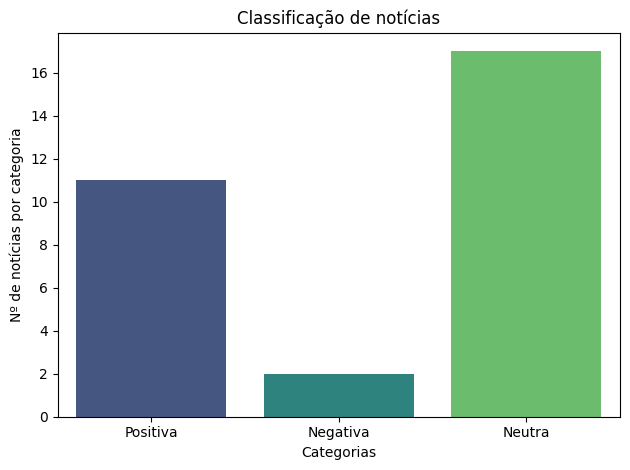

In [45]:
sns.barplot(data=df_news, palette='viridis')
plt.xlabel('Categorias')
plt.ylabel('Nº de notícias por categoria')
plt.title('Classificação de notícias')
plt.tight_layout()
plt.show()

# QUESTÃO 5

In [25]:
df_script = pd.read_csv('./Data/simpsons_script_lines.csv', low_memory=False)
df_episodes = pd.read_csv('./Data/simpsons_episodes.csv', low_memory=False)
df_characters = pd.read_csv('./Data/simpsons_characters.csv', low_memory=False)
df_locations = pd.read_csv('./Data/simpsons_locations.csv', low_memory=False)

df_script.set_index('id', inplace=True)
df_characters['id'] = df_characters['id'].astype(str)

df_characters = df_characters.add_prefix('character_')
df_locations = df_locations.add_prefix('location_')
df_episodes = df_episodes.add_prefix('episode_')

data = (
    df_script.merge(df_episodes, left_on='episode_id', right_on='episode_id')
             .merge(df_characters, left_on='character_id', right_on='character_id', how='left')
             .merge(df_locations, left_on='location_id', right_on='location_id', how='left')
)
data.head()

,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,...,episode_season,episode_title,episode_us_viewers_in_millions,episode_video_url,episode_views,character_name,character_normalized_name,character_gender,location_name,location_normalized_name
0,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,true,464,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",...,2,Lisa's Substitute,17.7,http://www.simpsonsworld.com/video/288011331912,52770.0,Miss Hoover,miss hoover,f,Springfield Elementary School,springfield elementary school
1,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,true,9,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,...,2,Lisa's Substitute,17.7,http://www.simpsonsworld.com/video/288011331912,52770.0,Lisa Simpson,lisa simpson,f,Springfield Elementary School,springfield elementary school
2,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,true,464,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,...,2,Lisa's Substitute,17.7,http://www.simpsonsworld.com/video/288011331912,52770.0,Miss Hoover,miss hoover,f,Springfield Elementary School,springfield elementary school
3,32,212,Lisa Simpson: That life is worth living.,864000,true,9,3.0,Lisa Simpson,Springfield Elementary School,That life is worth living.,...,2,Lisa's Substitute,17.7,http://www.simpsonsworld.com/video/288011331912,52770.0,Lisa Simpson,lisa simpson,f,Springfield Elementary School,springfield elementary school
4,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,true,40,3.0,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,...,2,Lisa's Substitute,17.7,http://www.simpsonsworld.com/video/288011331912,52770.0,Edna Krabappel-Flanders,edna krabappel-flanders,f,Springfield Elementary School,springfield elementary school


In [27]:
def estimar_tokens(texto):
    encoder = tiktoken.get_encoding("cl100k_base")
    tokens = encoder.encode(texto)
    return tokens

X = data.dropna(subset='normalized_text').copy()
X['n_tokens'] = X.normalized_text.fillna('').apply(lambda x: len(estimar_tokens(x)))
X.shape

(132087, 31)

In [ ]:
# Tokens por EP
X.groupby('episode_id').n_tokens.sum().mean()

np.float64(2606.982269503546)

In [ ]:
# Tokens por temporada
X.groupby('episode_season').n_tokens.sum().mean()

np.float64(56551.46153846154)

In [32]:
cols = ['episode_id', 'episode_season','episode_original_air_date', 'episode_imdb_rating', 
        'episode_imdb_votes', 'episode_us_viewers_in_millions', 'episode_views']
episode_stats = data[cols].drop_duplicates()

episode_stats.to_csv('series_data.csv', sep=';', index=None)

In [ ]:
prompt_start = f"""
You are a data scientist specialized in analysing entertainment content. You are working on the show series
"The Simpsons", investigating patterns in the series series_data. 
How can we evaluate the relationship between episode ratings ('episode_imdb_rating', 'episode_imdb_votes')
and audiences ('episode_us_viewers_in_millions', 'episode_views') in series_data.csv, considering it a CSV file
splitted by ';' with columns:

- episode_id: episode unique identifier
- episode_season: episode season number
- episode_original_air_date: date that the episode was first exhibited
- episode_imdb_rating: episode with the IMDB rating 
- episode_imdb_votes: episode with the number of voters
- episode_us_viewers_in_millions: number of episode viewers (in millions)
- episode_views: total number of episode views.

Generate a list of 3 analyses that can be implemented given the available series_data, as a JSON file:
{[
    {'Name':'analysis name',
     'Objective': 'what we need to analyze',
     'Method': 'how we analyze it'
    }
]
}
"""

genai.configure(api_key=os.environ["GEMINI_API_KEY"])
model = genai.GenerativeModel("gemini-1.5-pro")
response = model.generate_content(prompt_start)
analysis = json.loads(response.text.replace("```json\n",'').replace("\n```",''))
analysis

[{'Name': 'Correlation Analysis',
  'Objective': 'To determine the strength and direction of the linear relationship between IMDB ratings/votes and viewership metrics.',
  'Method': "Calculate Pearson correlation coefficients between 'episode_imdb_rating', 'episode_imdb_votes' and 'episode_us_viewers_in_millions', 'episode_views'.  Visualize the relationships using scatter plots with trend lines.  This will help understand if higher ratings correlate with higher viewership."},
 {'Name': 'Regression Analysis',
  'Objective': 'To model the relationship between IMDB ratings/votes (as predictors) and viewership (as target variables).',
  'Method': "Build linear regression models with 'episode_imdb_rating' and 'episode_imdb_votes' as independent variables and 'episode_us_viewers_in_millions' and 'episode_views' separately as dependent variables. Evaluate model performance using metrics like R-squared and RMSE. This helps quantify the impact of ratings and votes on viewership."},
 {'Name': '

In [34]:
prompt_analysis = f"""
You are a data scientist specialized in analysing entertainment content. You are working on the show series
"The Simpsons", investigating patterns in the series series_data. 
How can we evaluate the relationship between episode ratings ('episode_imdb_rating', 'episode_imdb_votes')
and audiences ('episode_us_viewers_in_millions', 'episode_views') in "series_data.csv", considering it a CSV file
splitted by ';' with columns:

- episode_id: episode unique identifier
- episode_season: episode season number
- episode_original_air_date: date that the episode was first exhibited
- episode_imdb_rating: episode with the IMDB rating 
- episode_imdb_votes: episode with the number of voters
- episode_us_viewers_in_millions: number of episode viewers (in millions)
- episode_views: total number of episode views.

Implement the analysis described below in python.
Output only the code, no need for explanations.
## ANALYSIS
{analysis[0]}
"""

genai.configure(api_key=os.environ["GEMINI_API_KEY"])
model = genai.GenerativeModel("gemini-1.5-pro")
response = model.generate_content(prompt_analysis)
print(response.text)

```python
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

series_data = pd.read_csv("series_data.csv", sep=";")

# Calculate Pearson correlation coefficients
correlation_matrix = series_data[['episode_imdb_rating', 'episode_imdb_votes', 'episode_us_viewers_in_millions', 'episode_views']].corr()
print(correlation_matrix)

# Visualize relationships with scatter plots and trend lines
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.regplot(x='episode_imdb_rating', y='episode_us_viewers_in_millions', data=series_data)
plt.title('IMDB Rating vs. US Viewers')

plt.subplot(2, 2, 2)
sns.regplot(x='episode_imdb_rating', y='episode_views', data=series_data)
plt.title('IMDB Rating vs. Total Views')

plt.subplot(2, 2, 3)
sns.regplot(x='episode_imdb_votes', y='episode_us_viewers_in_millions', data=series_data)
plt.title('IMDB Votes vs. US Viewers')

plt.subplot(2, 2, 4)
sns.regplot(x='episode_imdb_votes', y='episode_views', data=series_data)
plt.title('IMDB Votes vs.

                                episode_imdb_rating  episode_imdb_votes  \
episode_imdb_rating                        1.000000            0.780556   
episode_imdb_votes                         0.780556            1.000000   
episode_us_viewers_in_millions             0.610862            0.768896   
episode_views                              0.594384            0.655752   

                                episode_us_viewers_in_millions  episode_views  
episode_imdb_rating                                   0.610862       0.594384  
episode_imdb_votes                                    0.768896       0.655752  
episode_us_viewers_in_millions                        1.000000       0.516846  
episode_views                                         0.516846       1.000000  


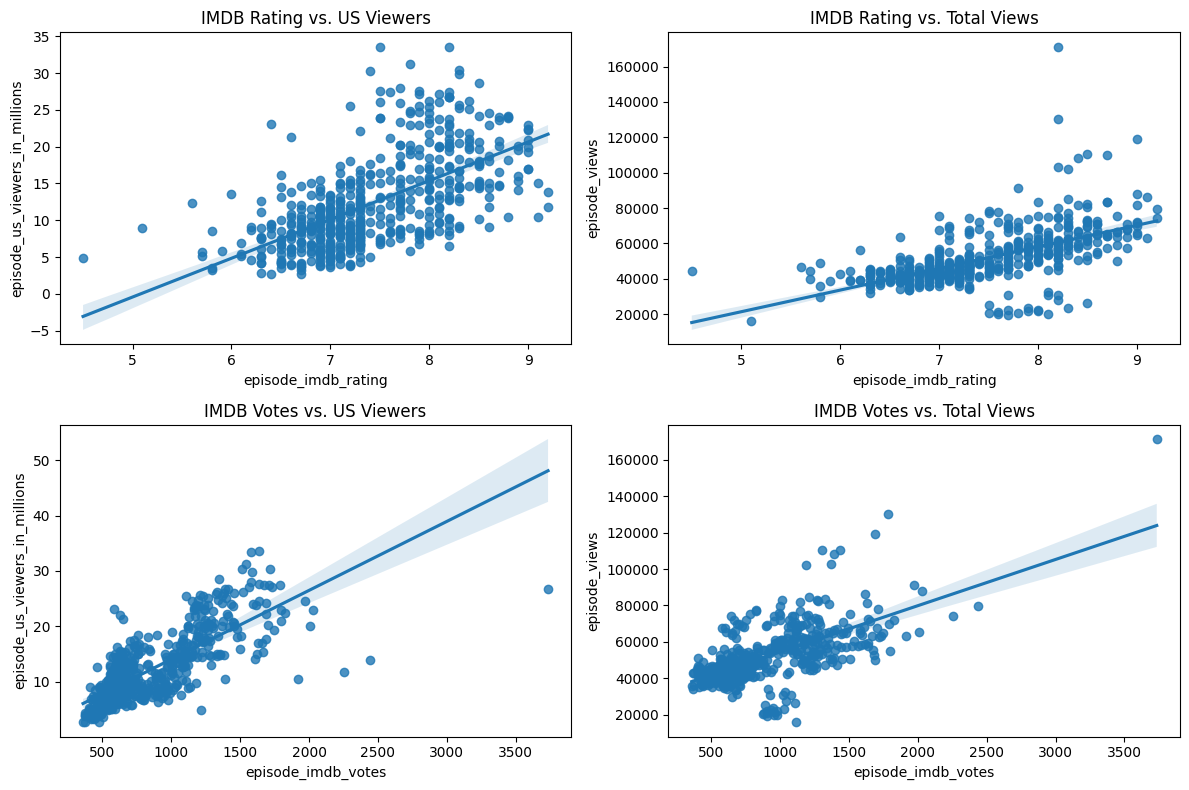

In [36]:
series_data = pd.read_csv("series_data.csv", sep=";")

# Calculate Pearson correlation coefficients
correlation_matrix = series_data[['episode_imdb_rating', 'episode_imdb_votes', 'episode_us_viewers_in_millions', 'episode_views']].corr()
print(correlation_matrix)

# Visualize relationships with scatter plots and trend lines
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.regplot(x='episode_imdb_rating', y='episode_us_viewers_in_millions', data=series_data)
plt.title('IMDB Rating vs. US Viewers')

plt.subplot(2, 2, 2)
sns.regplot(x='episode_imdb_rating', y='episode_views', data=series_data)
plt.title('IMDB Rating vs. Total Views')

plt.subplot(2, 2, 3)
sns.regplot(x='episode_imdb_votes', y='episode_us_viewers_in_millions', data=series_data)
plt.title('IMDB Votes vs. US Viewers')

plt.subplot(2, 2, 4)
sns.regplot(x='episode_imdb_votes', y='episode_views', data=series_data)
plt.title('IMDB Votes vs. Total Views')

plt.tight_layout()
plt.show()

# QUESTÃO 6

In [38]:
episode_season = 5
episode_id = 92
ep92 = (data[(data.episode_season == episode_season) &
          (data.episode_id == episode_id)].sort_values('number')
)
ep92 = ep92.dropna(subset='normalized_text')

In [40]:
positivas = [
    "that life is worth living",
    "i am the champions i am the champions no time for losers cause i am the champions of the worlllld",
    "eh you must be bart simpson well you look like youve got a strong young back",
    "Every day is a chance to turn things around and shine brighter.",
    "I believe in my dreams, and nothing can hold me back."
]

negativas = [
    "i dont think theres anything left to say",
    "we came to this retreat because i thought our marriage was in trouble but i never for a minute thought it was in this much trouble homer how can you expect me to believe",
    "oh thats my brother asa he was killed in the great war held a grenade too long",
    "I can’t shake the feeling that things are only going to get worse.",
    "No matter how hard I try, it feels like nothing ever changes."
]

neutras = [
    "wheres mr bergstrom",
    "would you have to do extra work",
    "oh please dad i want this more than anything in the world",
    "Can you tell me what time the meeting starts?",
    "I noticed the weather has been quite unpredictable lately."
]

In [41]:
prompt = f"""
You are an expert in human communication and marketing, specialized in sentiment analysis.
You have to classify lines from a cartoon show as negative, neutral and positive as defined below:
- positive: happy, constructive, hopefull, joy and similar lines.
- negative: sad, destructive, hopeless, angressive and similar lines.
- neutral: indifferent, objetive, formal and lines classified neigher as positive or negative.

Some pre-classified lines from this show are listed here:

# Positive:
{ '- '.join(positivas) }


# Negative:
{ '- '.join(negativas) }


# Neutral:
{ '- '.join(neutras) }

Given this information, respond in JSON with the classification of these other lines as positive, negative or neutral.


{ '- '.join(X.normalized_text.tolist()[:100]) }

"""
# Definir a chave de API do Gemini (use a chave fornecida pela sua conta)
genai.configure(api_key=os.environ["GEMINI_API_KEY"])
model = genai.GenerativeModel("gemini-1.5-pro")
response = model.generate_content(prompt)
print(response.text)

```json
{
  "no actually it was a little of both sometimes when a disease is in all the magazines and all the news shows its only natural that you think you have it": "neutral",
  "wheres mr bergstrom": "neutral",
  "i dont know although id sure like to talk to him he didnt touch my lesson plan what did he teach you": "neutral",
  "that life is worth living": "positive",
  "the polls will be open from now until the end of recess now just in case any of you have decided to put any thought into this well have our final statements martin": "neutral",
  "i dont think theres anything left to say": "negative",
  "bart": "neutral",
  "victory party under the slide": "positive",
  "mr bergstrom mr bergstrom": "neutral",
  "hey hey he moved out this morning he must have a new job -- he took his copernicus costume": "neutral",
  "do you know where i could find him": "neutral",
  "i think hes taking the next train to capital city": "neutral",
  "the train how like him traditional yet environmenta

In [42]:
sentiments = json.loads(response.text.replace("```json\n",'').replace("\n```",''))
sentiments = pd.DataFrame().from_dict(sentiments, orient='index').reset_index()
sentiments.columns = ['normalized_text', 'sentiment']

In [43]:
sentiments

,normalized_text,sentiment
0,no actually it was a little of both sometimes ...,neutral
1,wheres mr bergstrom,neutral
2,i dont know although id sure like to talk to h...,neutral
3,that life is worth living,positive
4,the polls will be open from now until the end ...,neutral
...,...,...
89,and is this martin guy going to get to do anyt...,neutral
90,well no,negative
91,so let the baby have his bottle huh thats my m...,negative
92,hey thanks monkey-man,positive


Apenas uma chamada ao LLM foi necessária para a tarefa.

In [47]:
# Distribuição de falas por categoria

distribution = sentiments['sentiment'].value_counts()
distribution_percentage = sentiments['sentiment'].value_counts(normalize=True) * 100

print("Distribuição de sentimentos:")
print(distribution)
print("\nDistribuição de Sentimentos (Porcentagem):")
print(distribution_percentage)

Distribuição de sentimentos:
sentiment
neutral     47
negative    32
positive    15
Name: count, dtype: int64

Distribuição de Sentimentos (Porcentagem):
sentiment
neutral     50.000000
negative    34.042553
positive    15.957447
Name: proportion, dtype: float64


In [59]:
sentiments[sentiments['sentiment'] == 'positive'].head(5)

,normalized_text,sentiment
3,that life is worth living,positive
7,victory party under the slide,positive
15,hey thanks for your vote man,positive
17,well you got that right thanks for your vote g...,positive
24,yayyyyyyyyyyyyyy,positive


100% de acurácia para os sentimentos positivos.

In [60]:
sentiments[sentiments['sentiment'] == 'neutral'].head(5)

,normalized_text,sentiment
0,no actually it was a little of both sometimes ...,neutral
1,wheres mr bergstrom,neutral
2,i dont know although id sure like to talk to h...,neutral
4,the polls will be open from now until the end ...,neutral
6,bart,neutral


Acurácia de 60%, pois as frases contidas nos index 2 e 4 poderiam ser classificadas como negativas.

In [61]:
sentiments[sentiments['sentiment'] == 'negative'].head(5)

,normalized_text,sentiment
5,i dont think theres anything left to say,negative
16,i didnt vote votings for geeks,negative
20,uh oh,negative
27,no,negative
35,oh i mean were you just going to leave just li...,negative


80% de acurácia, pois não fica clara a emoção contida na expressão "uh oh".

# QUESTÃO 7

# QUESTÃO 8

In [79]:
data.columns

Index(['episode_id', 'number', 'raw_text', 'timestamp_in_ms', 'speaking_line',
       'character_id', 'location_id', 'raw_character_text',
       'raw_location_text', 'spoken_words', 'normalized_text', 'word_count',
       'episode_image_url', 'episode_imdb_rating', 'episode_imdb_votes',
       'episode_number_in_season', 'episode_number_in_series',
       'episode_original_air_date', 'episode_original_air_year',
       'episode_production_code', 'episode_season', 'episode_title',
       'episode_us_viewers_in_millions', 'episode_video_url', 'episode_views',
       'character_name', 'character_normalized_name', 'character_gender',
       'location_name', 'location_normalized_name'],
      dtype='object')

In [77]:
from google.generativeai.types import HarmCategory, HarmBlockThreshold


class ChunkSummary():
    def __init__(self, model_name, apikey, text, window_size,
                 overlap_size, system_prompt, generation_config=None):
        self.text = text
        if isinstance(self.text, str):
            self.text = [self.text]
        self.window_size = window_size
        self.overlap_size = overlap_size
        # Aplicacao dos chunks e criacao do modelo
        self.chunks = self.__text_to_chunks()
        self.model = self.__create_model(apikey, model_name, 
                                         system_prompt, generation_config)
        


    def __create_model(self, apikey, model_name, system_prompt, generation_config=None):
        genai.configure(api_key=apikey)
        safety_settings={
            HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_NONE,
            HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_NONE,
            HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_NONE,
            HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_NONE,
        }
        if generation_config is None:
            generation_config = {
                'temperature': 0.2,
                'top_p': 0.8,
                'top_k': 20,
                'max_output_tokens': 1000
            }
        return genai.GenerativeModel(
            model_name,
            system_instruction=system_prompt,
            generation_config = generation_config,
            safety_settings=safety_settings
        )


    
    def __text_to_chunks(self):       
        n = self.window_size  # Tamanho de cada chunk
        m = self.overlap_size  # overlap entre chunks
        return [self.text[i:i+n] for i in range(0, len(self.text), n-m)]


    def __create_chunk_prompt(self, chunk, prompt_user):
        episode_lines = '\n'.join(chunk)
        prompt = f"""
        Summarize each chunk in order to attend to the # USER interaction:
        # USER
        {prompt_user}
        # OUTPUT INSTRUCTION
        The summary output must be written as a plain JSON with field 'summary'.
        ###### CHUNK
        {episode_lines}
        ######
        Summarize it.
        """
        return prompt
        
    
    def __summarize_chunks(self, prompt_user):
        # Loop over chunks
        chunk_summaries = []
        for i, chunk in enumerate(self.chunks):
            print(f'Summarizing chunk {i+1} from {len(self.chunks)}')
            # Create prompt
            prompt = self.__create_chunk_prompt(chunk, prompt_user)
            response = self.model.generate_content(prompt)
            # Apendar resposta do chunk
            chunk_summaries.append(response.text)

        return chunk_summaries


    def summarize(self, prompt_user):
        print('Summarizing text')
        # Chamar o sumario dos chunks
        self.chunk_summaries = self.__summarize_chunks(prompt_user)
        # Prompt final
        summaries = [f"- {x}\n" for x in self.chunk_summaries]
        prompt_summary = f"""
        # User: {prompt_user} 
        ### chunk summaries
        {summaries}
        ###
        
        Attend to the # User considering the information in ### chunk summaries.
        Write the output in JSON format with a field 'assistant'.
        """
        print('Interacting')
        response = self.model.generate_content(prompt_summary)
        
        return response.text

In [81]:
X.columns

Index(['episode_id', 'number', 'raw_text', 'timestamp_in_ms', 'speaking_line',
       'character_id', 'location_id', 'raw_character_text',
       'raw_location_text', 'spoken_words', 'normalized_text', 'word_count',
       'episode_image_url', 'episode_imdb_rating', 'episode_imdb_votes',
       'episode_number_in_season', 'episode_number_in_series',
       'episode_original_air_date', 'episode_original_air_year',
       'episode_production_code', 'episode_season', 'episode_title',
       'episode_us_viewers_in_millions', 'episode_video_url', 'episode_views',
       'character_name', 'character_normalized_name', 'character_gender',
       'location_name', 'location_normalized_name'],
      dtype='object')

In [78]:
system_prompt = f"""
You are an editor assistant from the "The Simpsons" show.
You will receive the subtitles from real episodes in the format:
<location>, <character> said: <character line>
"""
user_prompt = f"""
You must create a summary of the episode, pointing out the most
relevant information and key players in the story. Bare in mind
that the summary must describe how the episode started, which key
points are relevant along the story and its gran finale.
"""

# Filtrar dados
episode_season = 5
episode_id = 92
X = (data[(data.episode_season == episode_season) &
          (data.episode_id == episode_id)].sort_values('number')
)
X = X.dropna(subset='normalized_text')

episode_summarizer = ChunkSummary(
    model_name = "gemini-1.5-pro",
    apikey = os.environ["GEMINI_API_KEY"],
    text = X['line'].tolist(),
    window_size = 40,
    overlap_size = 5,
    system_prompt=system_prompt,
)

episode_summary = episode_summarizer.summarize(user_prompt)
episode_summary = json.loads(episode_summary.replace("```json\n",'').replace("\n```",''))

KeyError: 'line'